# Linear and Logistic Regression (Minimal)

In [1]:
# Import
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

## Image Classification with Logistic Regression (Minimal)

In [3]:
# Hyperparameters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

### Dataset & Data loaders

In [4]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

100%|██████████| 9912422/9912422 [00:00<00:00, 116634997.60it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21330462.02it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34003438.73it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13695563.46it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Label:  4


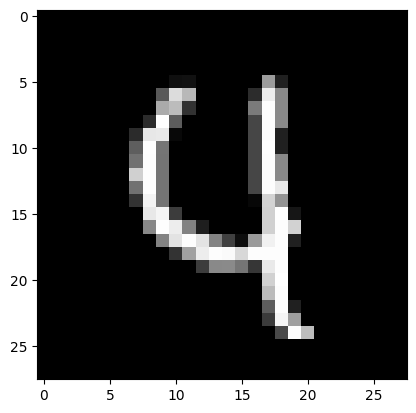

In [5]:
image, label = train_ds[0]
plt.imshow(image[0], cmap= 'gray')
print('Label: ', label)

### Model

In [9]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
      xb = xb.reshape(-1, 784)
      out = self.linear(xb)
      return out

  def training_step(self, batch):
      images, labels = batch
      out = self(images)
      loss = F.cross_entropy(out, labels)
      return loss

  def validation_step(self, batch):
      images, labels = batch
      out = self(images)
      loss = F.cross_entropy(out, labels)
      acc = accuracy(out, labels)
      return{'val_loss': loss.detach(), 'val_acc': acc.detach()}

  def validation_epoch_end(self, outputs):
       batch_losses = [x['val_loss'] for x in outputs]
       epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
       batch_accs = [x['val_acc'] for x in outputs]
       epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
       return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()


### Training

In [11]:
model

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
evaluate(model, val_loader)

{'val_loss': 2.3226122856140137, 'val_acc': 0.11005859076976776}

In [14]:
history = fit(10, 0.001, model, train_loader, val_loader)

Epoch [1], val_loss: 1.6801, val_acc: 0.7188
Epoch [2], val_loss: 1.4775, val_acc: 0.7604
Epoch [3], val_loss: 1.3247, val_acc: 0.7815
Epoch [4], val_loss: 1.2072, val_acc: 0.7951
Epoch [5], val_loss: 1.1151, val_acc: 0.8055
Epoch [6], val_loss: 1.0413, val_acc: 0.8145
Epoch [7], val_loss: 0.9810, val_acc: 0.8181
Epoch [8], val_loss: 0.9308, val_acc: 0.8225
Epoch [9], val_loss: 0.8885, val_acc: 0.8246


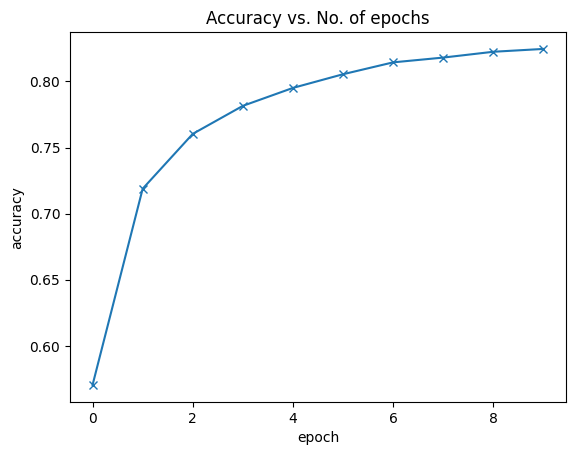

In [15]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [16]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.8618519902229309, 'val_acc': 0.8377929925918579}

### Prediction

In [17]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 6


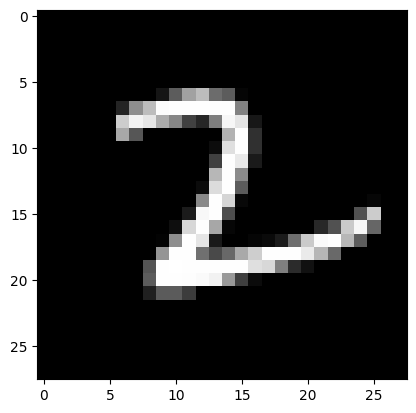

In [18]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


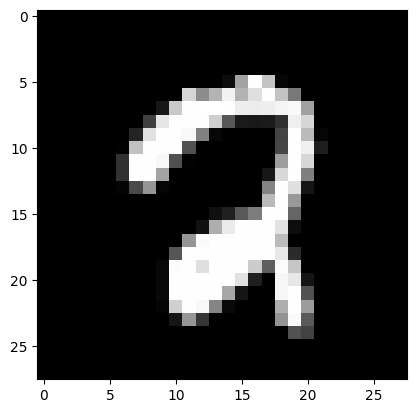

In [19]:
img, label = test_ds[119]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

## House price prediction using linear regression

In [20]:
# Imports
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [21]:
# Hyperparameters
batch_size=64
learning_rate=5e-7


# Other constants
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

### Dataset & Data loaders

In [22]:
# Download the data
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

100%|██████████| 35735/35735 [00:00<00:00, 15434399.49it/s]


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [23]:
# Converting from Pandas dataframe to numpy arrays

inputs = dataframe.drop('medv', axis=1).values
targets = dataframe[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [24]:
# Convert to PyTorch dataset

dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype= torch.float32))
train_ds, val_ds = random_split(dataset, [406, 100])


train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size*2)

### Model

In [29]:
class HousingModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, output_size)

  def forward(self, xb):
    out = self.linear(xb)
    return out

  def training_step(self, batch):
    inputs, targets = batch
    out = self(inputs)
    loss = F.mse_loss(out, targets)
    return loss

  def validation_step(self, batch):
    inputs, targets = batch
    out = self(inputs)
    loss = F.mse_loss(out, targets)
    return {'val_loss' : loss.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    return {'val_loss': epoch_loss.item()}



  def epoch_end(self, epoch, result):

    print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))


model = HousingModel()



### Training

In [30]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
result = evaluate(model, val_loader)
result

{'val_loss': 4720.44482421875}

In [33]:
history = fit(20, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 81.9187
Epoch [1], val_loss: 80.0383
Epoch [2], val_loss: 78.0962
Epoch [3], val_loss: 76.5849
Epoch [4], val_loss: 75.9872
Epoch [5], val_loss: 75.8163
Epoch [6], val_loss: 74.1652
Epoch [7], val_loss: 73.9649
Epoch [8], val_loss: 74.6087
Epoch [9], val_loss: 72.9414
Epoch [10], val_loss: 73.8662
Epoch [11], val_loss: 72.6398
Epoch [12], val_loss: 72.1591
Epoch [13], val_loss: 72.0730
Epoch [14], val_loss: 72.8827
Epoch [15], val_loss: 72.6190
Epoch [16], val_loss: 72.5329
Epoch [17], val_loss: 71.0954
Epoch [18], val_loss: 71.6508
Epoch [19], val_loss: 70.8799


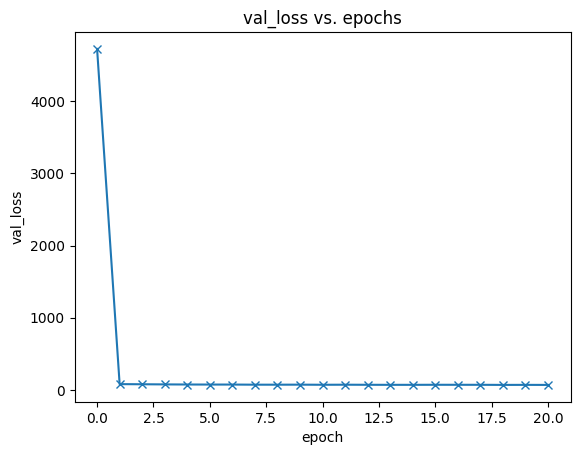

In [34]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

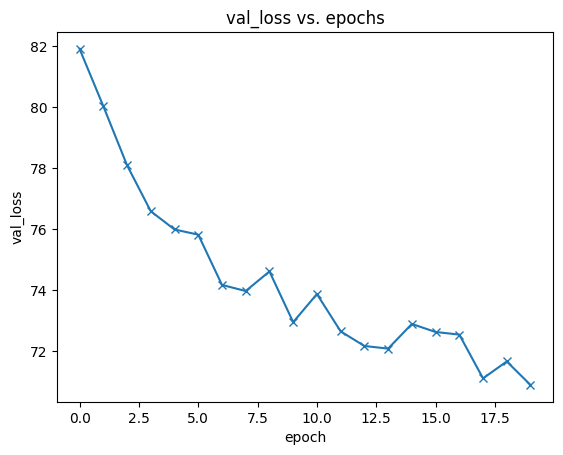

In [36]:
losses = [r['val_loss'] for r in  history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

### Prediction

In [37]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [41]:
x, target = val_ds[10]
x, target

(tensor([1.0793e-01, 0.0000e+00, 8.5600e+00, 0.0000e+00, 5.2000e-01, 6.1950e+00,
         5.4400e+01, 2.7778e+00, 5.0000e+00, 3.8400e+02, 2.0900e+01, 3.9349e+02,
         1.3000e+01]),
 tensor([21.7000]))

In [38]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([1.0793e-01, 0.0000e+00, 8.5600e+00, 0.0000e+00, 5.2000e-01, 6.1950e+00,
        5.4400e+01, 2.7778e+00, 5.0000e+00, 3.8400e+02, 2.0900e+01, 3.9349e+02,
        1.3000e+01])
Target:  21.700000762939453
Prediction: 25.287883758544922
